In [ ]:
from functions.adjust_cases_functions import prepare_cases 
from functions.general_utils import  get_bool
from models.seird_model import SEIRD

from statsmodels.tsa.arima.model import ARIMA


import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
import numpy as np
import os

from global_config import config


poly_run  = 11001
name_dir  = 'bogota'
drop_last_weeks = False

data_dir            = config.get_property('data_dir_covid')
geo_dir             = config.get_property('geo_dir')
data_dir_mnps       = config.get_property('data_dir_col')
results_dir         = config.get_property('results_dir')

agglomerated_folder = os.path.join(data_dir, 'data_stages', 'colombia', 'agglomerated', 'geometry' )
raw_folder          = os.path.join(data_dir, 'data_stages', 'colombia', 'raw', 'cases' )

polygons = pd.read_csv(os.path.join(agglomerated_folder, 'polygons.csv')).set_index('poly_id')
polygons = polygons.loc[poly_run]


data_raw  =  pd.read_csv(os.path.join(raw_folder, 'cases_raw.csv'), dayfirst=True)

data  =  pd.read_csv(os.path.join(agglomerated_folder, 'cases.csv'), parse_dates=['date_time'], dayfirst=True).set_index('poly_id')
data  = data.loc[poly_run].set_index('date_time')
data  = data.resample('D').sum().fillna(0)[['num_cases','num_diseased']]
data  = prepare_cases(data, col='num_cases', cutoff=0)   
data  = prepare_cases(data, col='num_diseased', cutoff=0)


In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(15.5, 14.2))

ax[0].plot(data.index.values, data.smoothed_num_cases, color='k', linewidth=2)
ax[0].scatter(data.index.values, data.num_cases, edgecolor='k', facecolor='w')

ax[1].plot(data.index.values, data.smoothed_num_diseased, color='r', linewidth=2)
ax[1].scatter(data.index.values, data.num_diseased, edgecolor='r', facecolor='w')


# ARIMA 

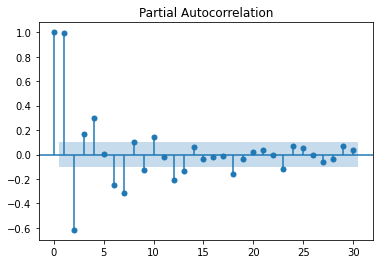

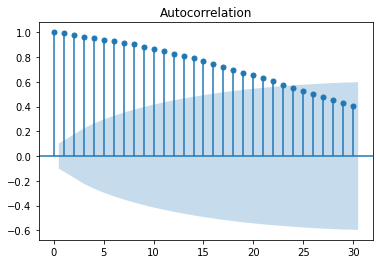

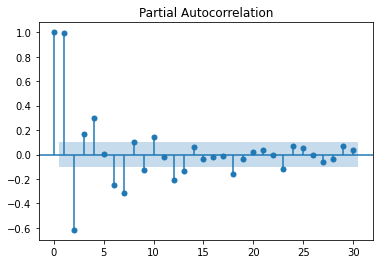

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data.smoothed_num_cases, lags=range(31))

plot_pacf(data.smoothed_num_cases, lags=range(31))

In [9]:
from statsmodels.tsa.stattools import acf, pacf

/Users/chaosdonkey06/conda/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


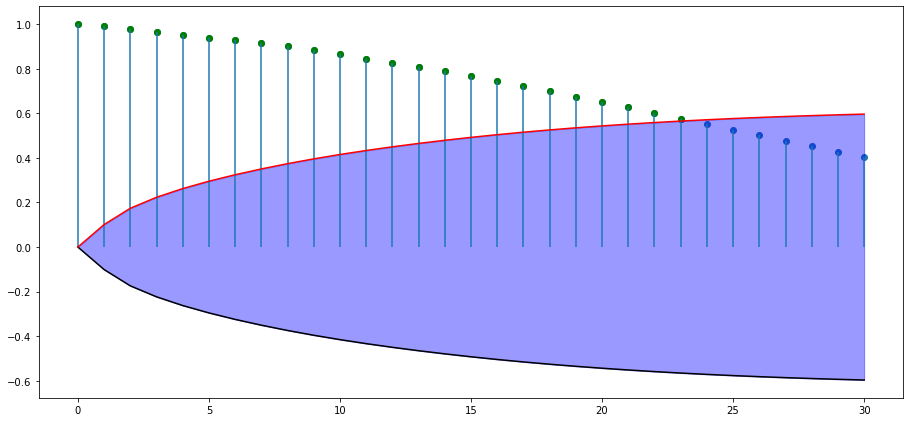

In [74]:


fig, ax = plt.subplots(1,1,figsize=(15.5, 7.2))
ax.scatter(range(31), a[0],)

ax.scatter(np.where(idx_keep)[0], a[0][idx_keep], color='green')

ax.vlines(range(31), [0], a[0] )
ax.fill_between(range(31), a[1][:,0]-a[0], a[1][:,1]-a[0], color='blue', alpha=0.4)

ax.plot(range(31), a[1][:,0]-a[0], color='k')
ax.plot(range(31), a[1][:,1]-a[0], color='red')

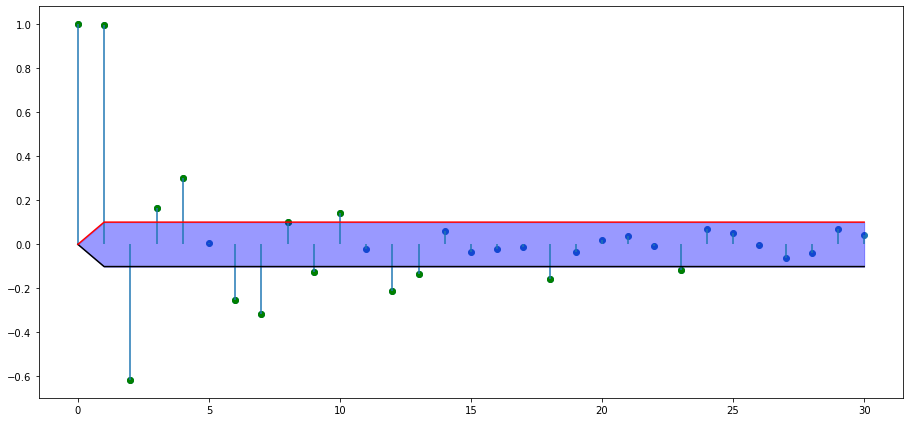

In [71]:
a = pacf(data.smoothed_num_cases, nlags=30, alpha=0.05)
idx_keep = (a[0]<= a[1][:,0]-a[0]) + (a[0]>= a[1][:,1]-a[0])

fig, ax = plt.subplots(1,1,figsize=(15.5, 7.2))
ax.scatter(range(31), a[0],)

ax.scatter(np.where(idx_keep)[0], a[0][idx_keep], color='green')

ax.vlines(range(31), [0], a[0] )
ax.fill_between(range(31), a[1][:,0]-a[0], a[1][:,1]-a[0], color='blue', alpha=0.4)

ax.plot(range(31), a[1][:,0]-a[0], color='k')
ax.plot(range(31), a[1][:,1]-a[0], color='red')

In [187]:
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

class ARIMA_model(object):
    @classmethod
    def fit_arima(cls, data, order):

        model = ARIMA(data, order=order).fit()
        aic   = model.aic
        return (model, aic)
    
    @classmethod
    def optimize_arima(cls, data, d_values=[1]):
        
        
        log_data = data.copy()
        log_data[log_data==0]+=1
        log_data = np.log(log_data)

        acf_d    = acf(log_data.diff().dropna(), nlags=30, alpha=0.05)
        p_values = np.where((acf_d[0]<= acf_d[1][:,0]-acf_d[0]) + (acf_d[0]>= acf_d[1][:,1]-acf_d[0]))[0]

        pacf_d   = pacf(log_data.diff().dropna(), nlags=30, alpha=0.05)
        q_values = np.where((pacf_d[0]<= pacf_d[1][:,0]-pacf_d[0]) + (pacf_d[0]>= pacf_d[1][:,1]-pacf_d[0]))[0]

        best_aic   = 0
        best_model = None
        best_cfg   = None
        
        for p in tqdm(p_values):
            for d in d_values:
                for q in q_values:
                    order = (p,d,q)
                    model, aic = cls.fit_arima(log_data, order=order)

                    if aic < best_aic:
                        best_aic, best_cfg = aic, order
                        best_model = model
    
        
        return (best_model, best_cfg, best_aic)
    
    def forecast_arima(cls, data=None, T_future=28, quantiles=[50, 80, 95]):


        if data is not None:

            (best_model, best_cfg, best_aic) = cls.optimize_arima(data)
            
            PredictionResultsWrapper = best_model.get_forecast(steps=T_future, dynamic=True)
            df_result = np.exp(PredictionResultsWrapper.conf_int(alpha=1))
            df_result.columns    = ['mean', 'median']
            df_result.index.name = 'date'
            
            for quant in quantiles:
                df_ci = np.exp(PredictionResultsWrapper.conf_int(alpha=1-quant/100))
                df_ci.columns = [f'low_{quant}', f'up_{quant}']
                df_ci.index.name = 'date'

                df_result = pd.merge(df_result, df_ci, left_index=True, right_index=True)
            
        return df_result

In [194]:
arima_model =  ARIMA_model()
df_cases  = arima_model.forecast_arima(data=data.smoothed_num_cases)
df_cases

100%|██████████| 11/11 [03:35<00:00, 19.56s/it]


,mean,median,low_50,up_50,low_80,up_80,low_95,up_95
date,,,,,,,,
2021-03-18,453.392401,453.392401,440.503315,466.658621,429.216333,478.930212,416.944588,493.026352
2021-03-19,435.990751,435.990751,410.112840,463.501546,388.137870,489.743336,364.970330,520.831200
2021-03-20,399.013471,399.013471,362.367894,439.364944,332.272460,479.160234,301.587393,527.912484
2021-03-21,380.153510,380.153510,332.755272,434.303234,295.170186,489.604635,258.167804,559.778131
2021-03-22,355.342580,355.342580,301.913928,418.226313,260.731348,484.285262,221.318440,570.527918
2021-03-23,333.907560,333.907560,277.840229,401.289112,235.474903,473.486803,195.726317,569.643677
2021-03-24,322.238597,322.238597,262.349008,395.799910,218.026017,476.262947,177.292699,585.685219
2021-03-25,310.270730,310.270730,247.886149,388.355405,202.539403,475.304676,161.604708,595.700005
2021-03-26,293.134912,293.134912,229.026737,375.187971,183.408567,468.506342,143.091856,600.509906


In [193]:
df_deaths  = arima_model.forecast_arima(data=data.smoothed_num_diseased)
df_deaths

100%|██████████| 8/8 [05:01<00:00, 37.69s/it]


,mean,median,low_50,up_50,low_80,up_80,low_95,up_95
date,,,,,,,,
2021-03-18,1.065072,1.065072,1.008992,1.124268,0.961048,1.180355,0.910159,1.246351
2021-03-19,1.067315,1.067315,0.978147,1.164610,0.904281,1.259741,0.828314,1.375276
2021-03-20,0.972169,0.972169,0.857092,1.102697,0.765214,1.235097,0.674140,1.401954
2021-03-21,0.917722,0.917722,0.786324,1.071077,0.684228,1.230896,0.585734,1.437876
2021-03-22,0.819358,0.819358,0.683800,0.981789,0.581081,1.155342,0.484435,1.385837
2021-03-23,0.816810,0.816810,0.665386,1.002694,0.553259,1.205907,0.450156,1.482106
2021-03-24,0.763246,0.763246,0.608336,0.957602,0.495989,1.174509,0.394801,1.475537
2021-03-25,0.729592,0.729592,0.568769,0.935890,0.454571,1.171004,0.353858,1.504291
2021-03-26,0.700828,0.700828,0.534505,0.918906,0.418846,1.172651,0.318941,1.539971


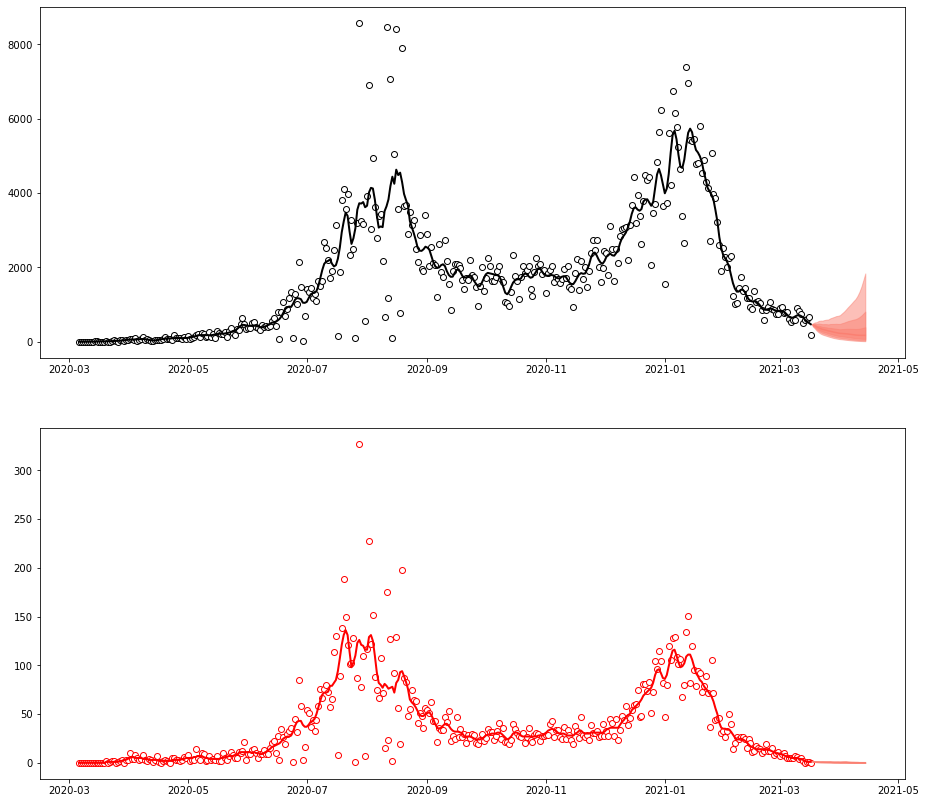

In [195]:
fig, ax = plt.subplots(2, 1, figsize=(15.5, 14.2))

ax[0].plot(data.index.values, data.smoothed_num_cases, color='k', linewidth=2)
ax[0].scatter(data.index.values, data.num_cases, edgecolor='k', facecolor='w')
ax[0].plot(df_cases.index.values, df_cases["mean"], color='salmon')

ax[0].fill_between(df_cases.index.values, df_cases.low_95, df_cases.up_95,
                   alpha=0.5, color='salmon')
ax[0].fill_between(df_cases.index.values, df_cases.low_80, df_cases.up_80,
                   alpha=0.5, color='salmon')
ax[0].fill_between(df_cases.index.values, df_cases.low_50, df_cases.up_50,
                   alpha=0.5, color='salmon')

ax[1].plot(data.index.values, data.smoothed_num_diseased, color='r', linewidth=2)
ax[1].scatter(data.index.values, data.num_diseased, edgecolor='r', facecolor='w')

ax[1].plot(df_deaths.index.values, df_deaths["mean"], color='salmon')

ax[1].fill_between(df_deaths.index.values, df_deaths.low_95, df_deaths.up_95,
                 alpha=0.5, color='salmon')
ax[1].fill_between(df_deaths.index.values, df_deaths.low_80, df_deaths.up_80,
                  alpha=0.5, color='salmon')
ax[1].fill_between(df_deaths.index.values, df_deaths.low_50, df_deaths.up_50,
                   alpha=0.5, color='salmon')

# Forecasting GAM

In [ ]:
import argparse
from os.path import exists
from urllib.request import urlopen

import numpy as np
import torch

import pyro
from pyro.contrib.timeseries import IndependentMaternGP, LinearlyCoupledMaternGP


# download dataset from UCI archive
def download_data():
    if not exists("eeg.dat"):
        url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00264/EEG%20Eye%20State.arff"
        with open("eeg.dat", "wb") as f:
            f.write(urlopen(url).read())
